# First coverage tests

We will initially make simple coverage tests in simple examples to see how our proposed test is doing. First we take the boston housing prices dataset:

In [11]:
# importing libraries
from sklearn.datasets import load_boston
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("Set1")

# original directory
path_original = os.getcwd()
# importing module
from lcv.valid_pred_sets import Valid_pred_sets
from lcv.valid_pred_sets import LinearQuantileRegression
from lcv.valid_pred_sets import GradientBoostingQuantileRegression

# returning to original directory
# figure path
images_dir = "figures"

In [2]:
# verifying path
os.getcwd()

'/home/kuben/estatistica_UFSCAR/Doutorado/lcv/results'

## Boston dataset

In [15]:
boston = load_boston()
idx = np.random.permutation(boston.target.size)

# Divide the data into proper training set, calibration set and test set
idx_train, idx_cal, idx_test = idx[:300], idx[300:399], idx[399:]

model = RandomForestRegressor()	# Create the underlying model
nc = NcFactory.create_nc(model)	# Create a default nonconformity function
icp = IcpRegressor(nc)			# Create an inductive conformal regressor

# Fit the ICP using the proper training set
icp.fit(boston.data[idx_train, :], boston.target[idx_train])

# Calibrate the ICP using the calibration set
icp.calibrate(boston.data[idx_cal, :], boston.target[idx_cal])

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dat

In [16]:
boston.data.shape

(506, 13)

Creating our hypothesis object:

In [4]:
# hypothesis object
hyp_obj = Valid_pred_sets(icp, 0.05)

In [5]:
# fitting and testing
hyp_obj.fit(boston.data[idx_test, :], boston.target[idx_test])

Valid_pred_sets(alpha=0.05,
                conf=IcpRegressor(condition=<function BaseIcp.__init__.<locals>.<lambda> at 0x7ff592f0cc10>,
                                  nc_function=RegressorNc(err_func=<nonconformist.nc.AbsErrorErrFunc object at 0x7ff5bd745610>,
                                                          model=RegressorAdapter(fit_params={},
                                                                                 model=RandomForestRegressor()))))

In [6]:
boston_icp_test = hyp_obj.monte_carlo_test()
boston_icp_test

{'p-value': 0.574, 'Observed statistic': 0.0454545454545455}

Testing quantile regression

In [17]:
# creating quantile regression object
lqr = LinearQuantileRegression(coverage = 0.05)

idx_train, idx_test = idx[:399], idx[399:]

# fitting
lqr.fit(boston.data[idx_train, :], boston.target[idx_train])

LinearQuantileRegression(coverage=0.05)

In [18]:
hyp_quantile_obj = Valid_pred_sets(lqr, 0.05)
hyp_quantile_obj.fit(boston.data[idx_test, :], boston.target[idx_test])

Valid_pred_sets(alpha=0.05, conf=LinearQuantileRegression(coverage=0.05))

In [19]:
boston_quantile_test = hyp_quantile_obj.monte_carlo_test()
boston_quantile_test

{'p-value': 0.33, 'Observed statistic': 0.05863636363636366}

## Simulated datasets
Now we will consider the same simulated datasets generated by Izbicki et.al (2022) to assess our hypothesis testing framework:

In [3]:
# importing simulated datasets module
from simulation import simulation

# shuffling and splitting in train, calibration and test sets
def split(X, y, test_size = 0.4, calibrate = True, random_seed = 1250):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size,
                                                        random_state = random_seed)
    if calibrate:
        X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = 0.25,
                                                             random_state = random_seed)
        return {"X_train":X_train, "X_calib": X_calib, "X_test" : X_test, 
                "y_train" : y_train, "y_calib" : y_calib, "y_test": y_test}
    else:
        return{"X_train":X_train,"X_test" : X_test, 
                "y_train" : y_train,"y_test": y_test}

General testing function that returns p-values for each interval prediction model:

In [4]:
# general testing function
def test_methods(kind = "homoscedastic", n = 10000, d = 20, coef = 2, B = 1000,
                 random_seed = 1250, sig = 0.05, coverage_evaluator = "RF"):
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp, split_quantile = split(sim_obj.X, sim_obj.y), split(sim_obj.X, sim_obj.y, calibrate = False)
    
    # testing first icp
    model = RandomForestRegressor(random_state = random_seed)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(split_icp["X_train"], split_icp["y_train"])
    icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
    hyp_icp = Valid_pred_sets(icp, sig, coverage_evaluator = coverage_evaluator)
    hyp_icp.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    res_icp = hyp_icp.monte_carlo_test(B = B, random_seed = random_seed)
    
    # testing gradient boosting quantile regression
    gbqr = GradientBoostingQuantileRegression(n_estimators = 200, random_state = random_seed)
    gbqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_gbqr_quant = Valid_pred_sets(gbqr, sig, coverage_evaluator = coverage_evaluator)
    hyp_gbqr_quant.fit(split_quantile["X_test"], split_quantile["y_test"], random_seed = random_seed)
    res_gbqr_quant = hyp_gbqr_quant.monte_carlo_test(B = B, random_seed = random_seed)
    
    # testing linear quantile regression
    lqr = LinearQuantileRegression(alpha = 1, solver = "highs")
    lqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_lqr_quant = Valid_pred_sets(lqr, sig, coverage_evaluator = coverage_evaluator)
    hyp_lqr_quant.fit(split_quantile["X_test"], split_quantile["y_test"], random_seed = random_seed)
    res_lqr_quant = hyp_lqr_quant.monte_carlo_test(B = B, random_seed = random_seed)
    
    return {"ICP":res_icp, 
            "GB Quantile Reg":res_gbqr_quant, 
            "Linear Quantile Reg":res_lqr_quant}

Plotting the ground truth quantiles versus each predicted interval:

In [5]:
def plot_intervals(kind = "homoscedastic", 
                   n = 10000, 
                   d = 20, 
                   coef = 2, 
                   random_seed = 1250, 
                   sig = 0.05,
                   alpha = 1,
                   figname = "plot.pdf"):
    # simulating data and then splitting into train and test sets
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp, split_quantile = split(sim_obj.X, sim_obj.y), split(sim_obj.X, sim_obj.y, calibrate = False)
    
    # fitting icp
    model = RandomForestRegressor(random_state = random_seed)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(split_icp["X_train"], split_icp["y_train"])
    icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
    
    # fitting gradient boosting quantile regression
    gbqr = GradientBoostingQuantileRegression(n_estimators = 200, random_state = random_seed)
    gbqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    
    # fitting linear quantile regression
    lqr = LinearQuantileRegression(alpha = alpha, solver = "highs")
    lqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    
    # plotting and comparing to the real quantiles
    # grid elements
    X_grid = np.linspace(-1.5, 1.5, num = 500)
    X_test = np.ones((500, d))
    X_test[:, 0] = X_grid
    
    # intervals
    # ground truth
    quant_kind = getattr(sim_obj, kind + "_quantiles")
    real_int = quant_kind(X_grid, sig)
    # icp
    icp_int = icp.predict(X_test, significance = sig)
    # gbqr
    gbqr_int = gbqr.predict(X_test)
    # lqr
    lqr_int = lqr.predict(X_test)
    
    # plotting
    plt.figure(figsize = (8, 6))
    # ground truth
    plt.plot(X_grid, real_int[:, 0], label = "Ground Truth", color = "royalblue")
    plt.plot(X_grid, real_int[:, 1], color = "royalblue")
    # icp
    plt.plot(X_grid, icp_int[:, 0], label = "ICP", color = "firebrick")
    plt.plot(X_grid, icp_int[:, 1], color = "firebrick")
    # gbqr
    plt.plot(X_grid, gbqr_int[:, 0], label = "GBQR", color = "darkgreen")
    plt.plot(X_grid, gbqr_int[:, 1], color = "darkgreen")
    # lqr
    plt.plot(X_grid, lqr_int[:, 0], label = "LQR", color = "darkorange")
    plt.plot(X_grid, lqr_int[:, 1], color = "darkorange")
    
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$y$")
    plt.legend(loc=1)
    plt.title("Quantiles comparisson for " + kind + " data")
    plt.tight_layout()
    # saving experiment figure
    plt.savefig(f"{images_dir}/{figname}")
    plt.show()

Function that plots the estimated $\hat{r}(x)$ alongside the real $r(x)$ versus $x_1$ for each method:

In [6]:
# support function
def r_real(model_preds, y_mat):
    r = np.zeros(model_preds.shape[0])
    for i in range(model_preds.shape[0]):
        r[i] = np.mean(np.logical_and(y_mat[i,:] >= model_preds[i, 0], y_mat[i, :] <= model_preds[i, 1]))
    return r

def plot_r(kind = "homoscedastic", 
           n = 10000, 
           d = 20, 
           coef = 2, 
           random_seed = 1250, 
           sig = 0.05,
           alpha = 1,
        coverage_evaluator = "RF",
        figname = "plot.pdf"):
    
    # simulating data and then splitting into train and test sets
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp, split_quantile = split(sim_obj.X, sim_obj.y), split(sim_obj.X, sim_obj.y, calibrate = False)
    
    # fitting icp
    model = RandomForestRegressor(random_state = random_seed)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(split_icp["X_train"], split_icp["y_train"])
    icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
    hyp_icp = Valid_pred_sets(icp, sig, coverage_evaluator = coverage_evaluator)
    hyp_icp.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # fitting gradient boosting quantile regression
    gbqr = GradientBoostingQuantileRegression(n_estimators = 200, random_state = random_seed)
    gbqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_gbqr = Valid_pred_sets(gbqr, sig, coverage_evaluator = coverage_evaluator)
    hyp_gbqr.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # fitting linear quantile regression
    lqr = LinearQuantileRegression(alpha = alpha, solver = "highs")
    lqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_lqr = Valid_pred_sets(lqr, sig, coverage_evaluator = coverage_evaluator)
    hyp_lqr.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # plotting and comparing to the real quantiles
    # grid elements
    X_grid = np.linspace(-1.5, 1.5, num = 500)
    X_test = np.ones((500, d))
    X_test[:, 0] = X_grid
    
    # r estimated values
    # icp
    icp_r = hyp_icp.r_prob(X_test)
    # gbqr
    gbqr_r = hyp_gbqr.r_prob(X_test)
    # lqr
    lqr_r = hyp_lqr.r_prob(X_test)
    
    # r real values
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_grid, B = 100000)
    # icp
    icp_r_real = r_real(icp.predict(X_test, significance = sig), y_mat)
    
    #gbqr
    gbqr_r_real = r_real(gbqr.predict(X_test), y_mat)
    
    # lqr
    lqr_r_real = r_real(lqr.predict(X_test), y_mat)
    
    # gathering all r values into a pandas data frame and then melting it
    r_mat = np.vstack((X_grid, icp_r, icp_r_real, gbqr_r, gbqr_r_real, lqr_r, lqr_r_real)).T
    r_data = pd.DataFrame(data = r_mat, columns = ['grid', "icp_r", 'icp_r_real', 'gbqr_r', 'gbqr_r_real',
                                                  'lqr_r', 'lqr_r_real'])
    
    # melting data
    r_melt = pd.melt(r_data, id_vars = ['grid'])
    names_cols = r_melt["variable"].to_list()
    r_melt["r_method"] = np.where(np.char.find(names_cols, "real") >= 0, 'real', 'estimated')
    r_melt["Model"] = np.where(np.char.find(names_cols, "icp") >= 0, 'icp',
                                   np.where(np.char.find(names_cols, "gbqr") >= 0, 'gbqr', 'lqr'))
    
    # plotting
    # setting wanted color palette
    g = sns.FacetGrid(r_melt, col = "Model", hue = "r_method",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
    
    g.map(sns.lineplot, "grid", "value")
    g.add_legend(loc = "upper right")
    g.set_ylabels(r"$r(x)$")
    g.set_xlabels(r"$x_1$")
    plt.tight_layout()
    # saving experiment figure
    plt.savefig(f"{images_dir}/{figname}")
    plt.show()

Function to plot neural network coverage evaluator history:

In [7]:
def plot_history(kind = "homoscedastic", 
           n = 10000, 
           d = 20, 
           coef = 2, 
           random_seed = 1250, 
           sig = 0.05,
           alpha = 1,
           figname = "plot.pdf"):
    
    # simulating data and then splitting into train and test sets
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp, split_quantile = split(sim_obj.X, sim_obj.y), split(sim_obj.X, sim_obj.y, calibrate = False)
    
    # fitting icp
    model = RandomForestRegressor(random_state = random_seed)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(split_icp["X_train"], split_icp["y_train"])
    icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
    hyp_icp = Valid_pred_sets(icp, sig, coverage_evaluator = "nnet")
    hyp_icp.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # fitting gradient boosting quantile regression
    gbqr = GradientBoostingQuantileRegression(n_estimators = 200, random_state = random_seed)
    gbqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_gbqr = Valid_pred_sets(gbqr, sig, coverage_evaluator = "nnet")
    hyp_gbqr.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # fitting linear quantile regression
    lqr = LinearQuantileRegression(alpha = alpha, solver = "highs")
    lqr.fit(split_quantile["X_train"], split_quantile["y_train"])
    hyp_lqr = Valid_pred_sets(lqr, sig, coverage_evaluator = "nnet")
    hyp_lqr.fit(split_icp["X_test"], split_icp["y_test"], random_seed = random_seed)
    
    # obtaining each historic and transforming each into a pandas data frame
    hist_icp, hist_gbqr, hist_lqr = hyp_icp.model.return_history_dict(), hyp_gbqr.model.return_history_dict(), hyp_lqr.model.return_history_dict() 
    hist_icp, hist_gbqr, hist_lqr = pd.DataFrame(hist_icp), pd.DataFrame(hist_gbqr), pd.DataFrame(hist_lqr)
    
    # identifying each data.frame with a flag
    hist_icp, hist_gbqr, hist_lqr = hist_icp.assign(model = "icp"), hist_gbqr.assign(model = "gbqr"), hist_lqr.assign(model = "lqr") 
    
    # bindind rows of each data frame and then melting
    all_hist = pd.concat([hist_icp, hist_gbqr, hist_lqr], ignore_index=True)
    all_hist = pd.melt(all_hist, id_vars = ['model', 'epoch'])
    
    g = sns.FacetGrid(all_hist, col = "model", hue = "variable",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
                      
    g.map(sns.lineplot, "epoch", "value")
    g.add_legend(loc = "upper right")
    g.set_ylabels("Loss")
    g.set_xlabels("Epoch")
    plt.tight_layout()
    # saving experiment figure
    plt.savefig(f"{images_dir}/{figname}")
    plt.show()   

### Homoscedastic simulated data

We can now test both quantile regression and inductive conformal prediction for the most simple kind of dataset. We will vary several distribution parameters and dataset settings starting with:
* $\beta_1 = 2$, $\sigma = 1$ and $d = 20$

Obtaning test results:

In [6]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing:")
res_hom = test_methods()
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing:
Time Elapsed:  4584.569003820419


{'ICP': {'p-value': 0.619, 'Observed statistic': 0.034725},
 'GB Quantile Reg': {'p-value': 0.07,
  'Observed statistic': 0.039124999999999986},
 'Linear Quantile Reg': {'p-value': 0.001,
  'Observed statistic': 0.04330000000000001}}

Plotting each quantile estimate, comparing it to ground truth

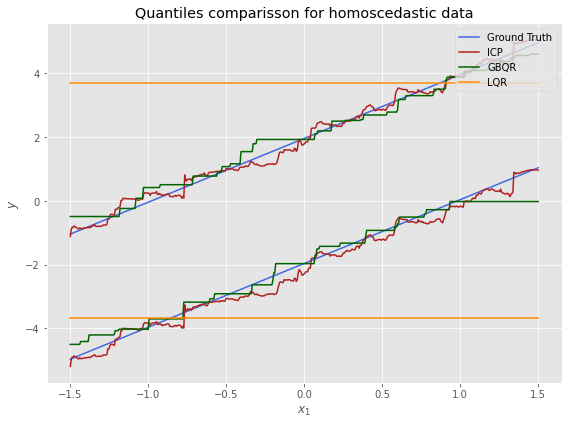

In [7]:
plot_intervals(figname = "quantile_homoc_beta1_2_d_20_sigma_1.pdf")

Plotting the estimated $\hat{r}(\boldsymbol{x})$ for each method

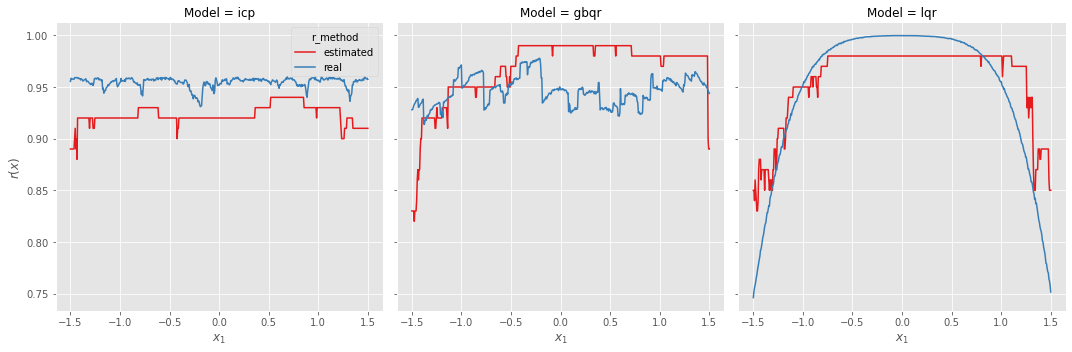

In [8]:
plot_r(figname = "rx_RF_homoc_beta1_2_d_20_sigma_1.pdf")

Estimating $\hat{r}(\boldsymbol{x})$ by neural network

Plotting r(x) for optimized nnet:


[I 2022-08-14 20:21:28,413] A new study created in memory with name: no-name-e819ad06-a5e6-4e05-b627-6de022350fbb
[I 2022-08-14 20:21:58,212] Trial 0 finished with value: 0.11644074693322182 and parameters: {'n_layers': 1, 'n_units_l0': 26, 'dropout_l0': 0.2175008215425142, 'optimizer': 'RMSprop', 'lr': 0.005679432815250312}. Best is trial 0 with value: 0.11644074693322182.
[I 2022-08-14 20:22:07,014] Trial 1 finished with value: 0.11238567810505629 and parameters: {'n_layers': 4, 'n_units_l0': 47, 'dropout_l0': 0.23032529809825056, 'n_units_l1': 44, 'dropout_l1': 0.4307933982426165, 'n_units_l2': 112, 'dropout_l2': 0.4342109630511539, 'n_units_l3': 102, 'dropout_l3': 0.42679448672765236, 'optimizer': 'RMSprop', 'lr': 0.001665289601082679}. Best is trial 1 with value: 0.11238567810505629.
[I 2022-08-14 20:22:30,102] Trial 2 finished with value: 0.1339472010731697 and parameters: {'n_layers': 2, 'n_units_l0': 24, 'dropout_l0': 0.20825592486227384, 'n_units_l1': 4, 'dropout_l1': 0.410683

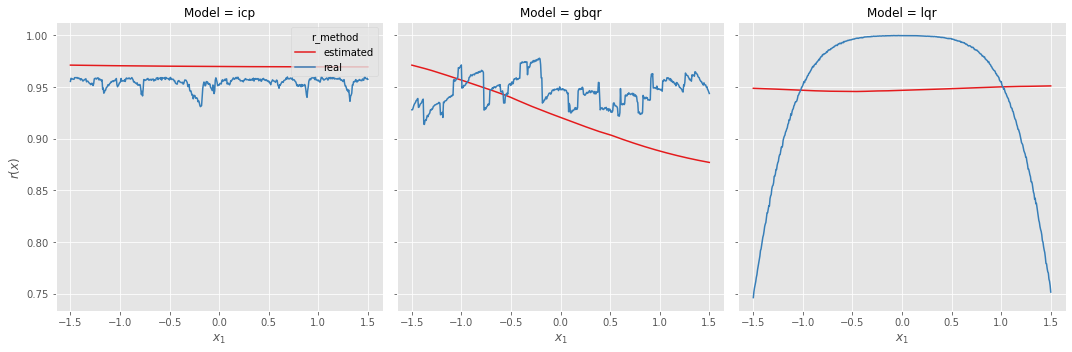

Time Elapsed:  811.7036280632019


In [7]:
start = time.time()
print("Plotting r(x) for optimized nnet:")
plot_r(coverage_evaluator = "nnet", figname = "rx_nnet__homoc_beta1_2_d_20_sigma_1.pdf")
end = time.time() - start
print("Time Elapsed: ", end)

Using other coverage evaluator such as logistic regression:

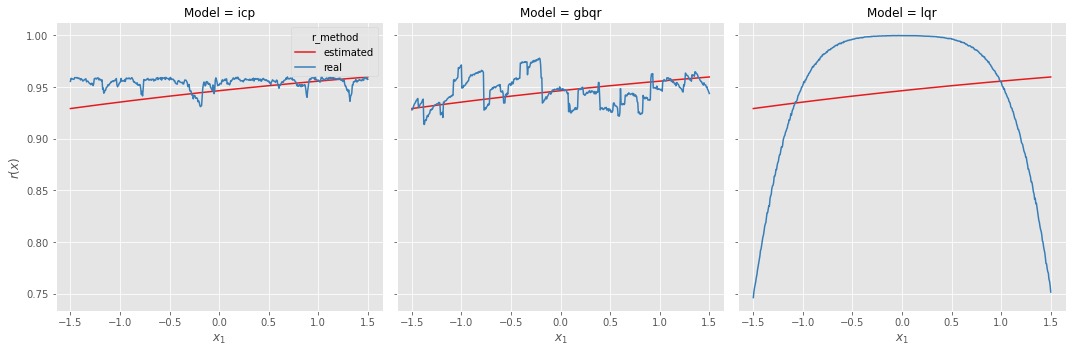

In [8]:
plot_r(coverage_evaluator = LogisticRegression(),figname = "rx_logistic_homoc_beta1_2_d_20_sigma_1.pdf")

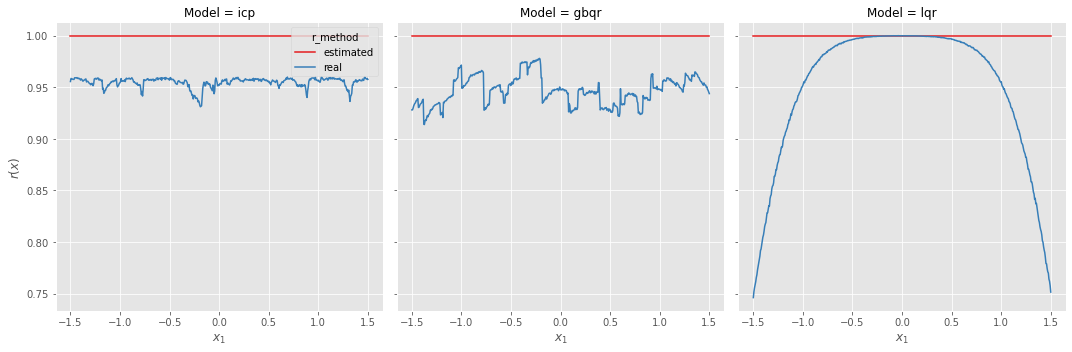

In [13]:
plot_r(coverage_evaluator = KNeighborsClassifier(n_neighbors = 5), figname = "rx_knn_homoc_beta1_2_d_20_sigma_1.pdf")

Visualizing neural net history for each model:

In [8]:
plot_history(figname = "historic_nnet_homoc_beta1_2_d_20_sigma_1.pdf")

[I 2022-08-14 20:35:02,471] A new study created in memory with name: no-name-ec71b2bf-4535-4def-b62f-5adf1b377a5c
[I 2022-08-14 20:35:12,476] Trial 0 finished with value: 0.11644074693322182 and parameters: {'n_layers': 1, 'n_units_l0': 26, 'dropout_l0': 0.2175008215425142, 'optimizer': 'RMSprop', 'lr': 0.005679432815250312}. Best is trial 0 with value: 0.11644074693322182.
[I 2022-08-14 20:35:22,049] Trial 1 finished with value: 0.11238567810505629 and parameters: {'n_layers': 4, 'n_units_l0': 47, 'dropout_l0': 0.23032529809825056, 'n_units_l1': 44, 'dropout_l1': 0.4307933982426165, 'n_units_l2': 112, 'dropout_l2': 0.4342109630511539, 'n_units_l3': 102, 'dropout_l3': 0.42679448672765236, 'optimizer': 'RMSprop', 'lr': 0.001665289601082679}. Best is trial 1 with value: 0.11238567810505629.
[I 2022-08-14 20:35:48,634] Trial 2 finished with value: 0.1339472010731697 and parameters: {'n_layers': 2, 'n_units_l0': 24, 'dropout_l0': 0.20825592486227384, 'n_units_l1': 4, 'dropout_l1': 0.410683

Performing hypothesis testing with neural network coverage evaluator

In [7]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing with nnet coverage evaluator:")
res_hom = test_methods(coverage_evaluator = "nnet")
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing with nnet coverage evaluator:
Time Elapsed:  15044.484607934952


{'ICP': {'p-value': 0.117, 'Observed statistic': 0.021655902},
 'GB Quantile Reg': {'p-value': 0.911, 'Observed statistic': 0.009267991},
 'Linear Quantile Reg': {'p-value': 0.0, 'Observed statistic': 0.04635259}}

Reducing $B$ to 100

In [7]:
start = time.time()
print("Homoscedastic data hypothesis testing with nnet coverage evaluator with B = 100:")
res_hom = test_methods(B = 100, coverage_evaluator = "nnet")
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing with nnet coverage evaluator with B = 100:
Time Elapsed:  2048.6274087429047


{'ICP': {'p-value': 0.0, 'Observed statistic': 0.02492491},
 'GB Quantile Reg': {'p-value': 0.99, 'Observed statistic': 0.0054190625},
 'Linear Quantile Reg': {'p-value': 0.0, 'Observed statistic': 0.03751855}}

Testing GAM coverage evaluator in order to reduce the time elapsed by nnets and to obtain better estimates than random forest

Obtaining $\hat{r}(x)$ using GAM as coverage evaluator:

100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/home/kuben/anaconda3/lib/python3.8/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/home/kuben/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
  9% (1 of 11) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:31/home/kuben/anaconda3/lib/python3.8/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/home/kuben/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.spa

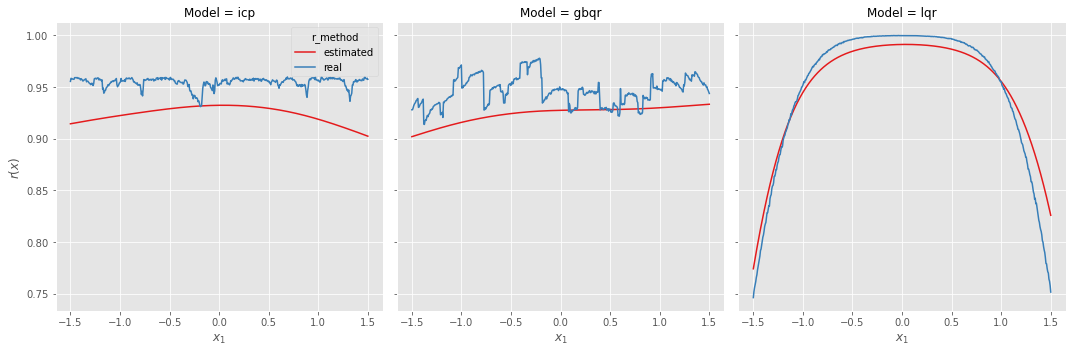

In [7]:
plot_r(coverage_evaluator = "GAM")

* Changing $d$ to only 1 to check if results are consistent:

In [90]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing:")
res_hom = test_methods(d = 1)
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing:


/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


Time Elapsed:  1947.2091002464294


{'ICP': {'p-value': 0.952, 'Observed statistic': 0.07310000000000003},
 'GB Quantile Reg': {'p-value': 0.088,
  'Observed statistic': 0.08895000000000003},
 'Linear Quantile Reg': {'p-value': 0.85,
  'Observed statistic': 0.07622500000000004}}

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


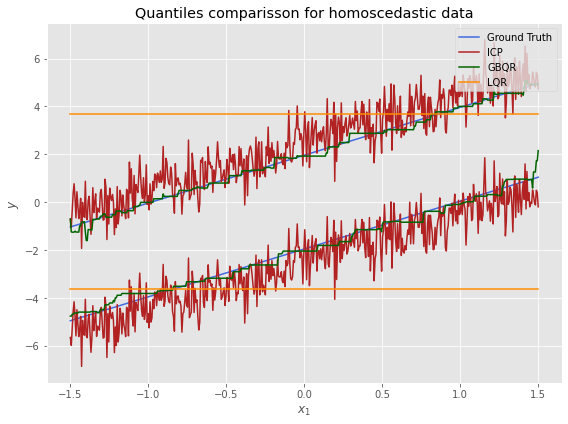

In [91]:
plot_intervals(d = 1, figname = "quantile_homoc_beta1_2_d_1_sigma_1.pdf")

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


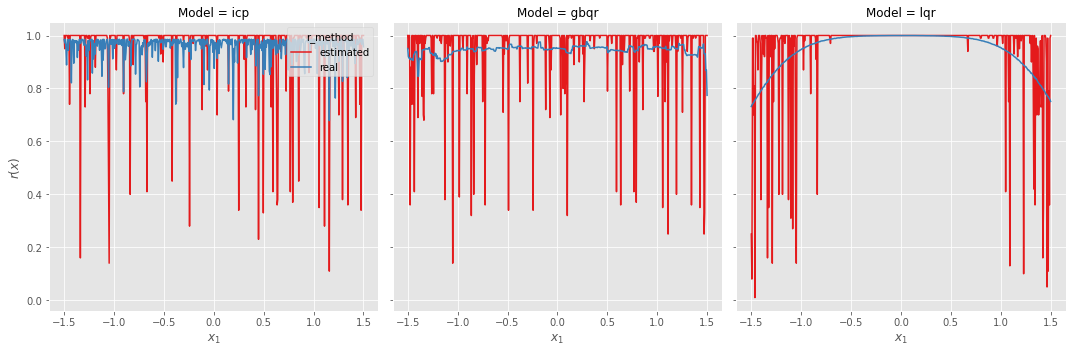

In [92]:
plot_r(d = 1, figname = "rx_RF_homoc_beta1_2_d_1_sigma_1.pdf")

$\hat{r}(\boldsymbol{x})$ with neural net

In [8]:
plot_r(d = 1, coverage_evaluator = "nnet", figname = "rx_nnet_homoc_beta1_2_d_1_sigma_1.pdf")

[I 2022-08-05 15:37:50,198] A new study created in memory with name: no-name-9302218c-5f40-4b36-99aa-5e38f0adf196
[W 2022-08-05 15:37:52,648] Trial 0 failed because of the following error: RuntimeError('CUDA error: all CUDA-capable devices are busy or unavailable\nCUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.')
Traceback (most recent call last):
  File "/home/kuben/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/home/kuben/estatistica_UFSCAR/Doutorado/lcv/lcv/coverage_evaluator.py", line 201, in _objective
    self.model = self._build_model(trial).to(DEVICE)
  File "/home/kuben/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py", line 927, in to
    return self._apply(convert)
  File "/home/kuben/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py",

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

Loss per epoch plot:

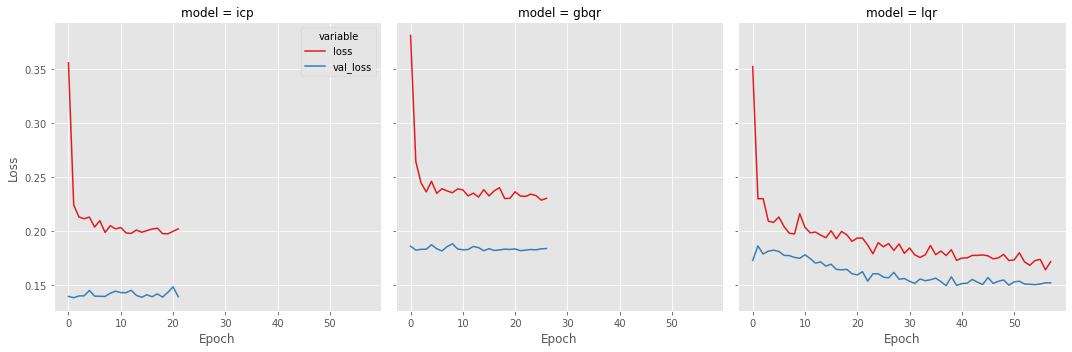

In [10]:
plot_history(d = 1, figname = "historic_nnet_homoc_beta1_2_d_1_sigma_1.pdf")

Fixing $d = 1$ for nnet coverage evaluator

In [13]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing with nnet coverage evaluator:")
res_hom = test_methods(d = 1, coverage_evaluator = "nnet")
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing with nnet coverage evaluator:
Time Elapsed:  14965.947530269623


{'ICP': {'p-value': 0.28, 'Observed statistic': 0.012040137},
 'GB Quantile Reg': {'p-value': 0.499, 'Observed statistic': 0.008109042},
 'Linear Quantile Reg': {'p-value': 0.0, 'Observed statistic': 0.06028128}}

Reducing $B$ to 100

In [8]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing with nnet coverage evaluator:")
res_hom = test_methods(d = 1, B = 100, coverage_evaluator = "nnet")
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing with nnet coverage evaluator:
Time Elapsed:  2719.7499697208405


{'ICP': {'p-value': 0.19, 'Observed statistic': 0.009462464},
 'GB Quantile Reg': {'p-value': 0.25, 'Observed statistic': 0.008490745},
 'Linear Quantile Reg': {'p-value': 0.0, 'Observed statistic': 0.050819326}}

In [111]:
sim_obj = simulation(dim = 1, coef = 2)
sim_kind = getattr(sim_obj, "homoscedastic")
sim_kind(10000, random_seed = 1250)
split_icp = split(sim_obj.X, sim_obj.y)

model = RandomForestRegressor(random_state = 1250)
nc = NcFactory.create_nc(model)
icp = IcpRegressor(nc)
icp.fit(split_icp["X_train"], split_icp["y_train"])
icp.calibrate(split_icp["X_calib"], split_icp["y_calib"])
X_calib, y_calib = split_icp["X_test"], split_icp["y_test"]
preds = icp.predict(X_calib, significance = 0.05)
np.random.seed(1250)
# obtaining each w
w = np.zeros(y_calib.shape[0])
for i in range(y_calib.shape[0]):
    w[i] = int(y_calib[i] >= preds[i, 0] and y_calib[i] <= preds[i, 1])
        # splitting training and testing sets
X_train, X_test, w_train, w_test = train_test_split(X_calib, w, test_size = 0.2)
        
# regressing w on x using random forest model
a = RandomForestClassifier().fit(X_train, w_train)
r = a.predict_proba(X_test)[:, 1]
t_obs = np.mean(np.abs(r  - (1 - 0.05)))

In [104]:
t_obs

0.07310000000000003

In [115]:
np.random.seed(1250)
B = 1250
t_b = np.zeros(B)

for i in range(B):
    new_w = stats.binom.rvs(n = 1, p = 1 - 0.05, size = w_train.shape[0])
    model_temp = RandomForestClassifier().fit(X_train, new_w)
    pred = model_temp.predict_proba(X_test)
    if len(pred[0]) == 1:
        new_r = pred
    else:
        new_r = pred[:, 1]
    t_b[i] = np.mean(np.abs(new_r - (1 - 0.05)))  

In [116]:
(t_b > t_obs).mean()

0.9488

In [118]:
np.mean(t_b)

0.08159073000000003

* Now testing for $\beta_1 = 0.3$ and $\sigma = 1$

In [76]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing for beta = 0.3:")
res_hom = test_methods(coef = 0.3)
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing for beta = 0.3:


/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


Time Elapsed:  5423.431742668152


{'ICP': {'p-value': 0.569, 'Observed statistic': 0.0349625},
 'GB Quantile Reg': {'p-value': 0.11,
  'Observed statistic': 0.03857499999999999},
 'Linear Quantile Reg': {'p-value': 0.274,
  'Observed statistic': 0.03683749999999999}}

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


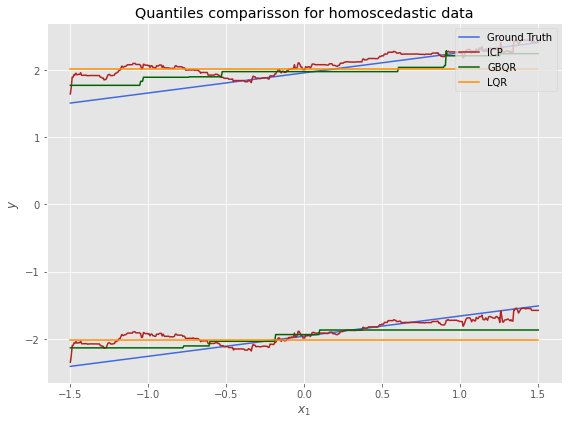

In [86]:
plot_intervals(coef = 0.3, figname = "quantile_homoc_beta1_0.3_d_20_sigma_1.pdf")

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


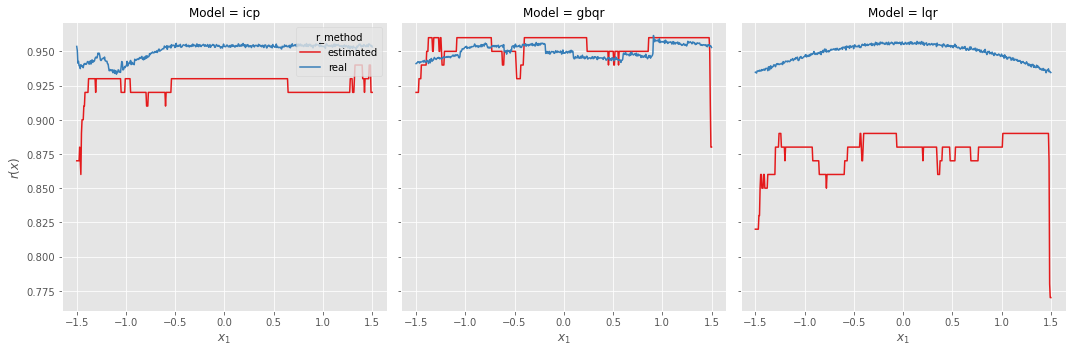

In [87]:
plot_r(coef = 0.3, figname = "rx_RF_homoc_beta1_0.3_d_20_sigma_1.pdf")

In [9]:
# using test_methods
# measuring time
start = time.time()
print("Homoscedastic data hypothesis testing for beta = 0.3 using nnets as coverage evaluator:")
res_hom = test_methods(coef = 0.3, B = 100, coverage_evaluator = "nnet")
end = time.time() - start
print("Time Elapsed: ", end)
res_hom

Homoscedastic data hypothesis testing for beta = 0.3 using nnets as coverage evaluator:
Time Elapsed:  2129.1903598308563


{'ICP': {'p-value': 0.07, 'Observed statistic': 0.018252602},
 'GB Quantile Reg': {'p-value': 0.97, 'Observed statistic': 0.006645009},
 'Linear Quantile Reg': {'p-value': 0.85, 'Observed statistic': 0.008677789}}

### Heteroscedastic simulated data

Now testing both quantile regression and inductive conformal prediction for heteroscedastic dataset. As done in homoscedastic experiments, we will vary some parameters, starting with:
#### $\beta_1 = 2 $ and $\sigma = \sqrt{(1 + 2*|x_1|)}$

In [79]:
# using test_methods
# measuring time
start = time.time()
print("Heteroscedastic data hypothesis testing:")
res_het = test_methods(kind = "heteroscedastic")
end = time.time() - start
print("Time Elapsed: ", end)
res_het

Heteroscedastic data hypothesis testing:


/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


Time Elapsed:  4987.836730480194


{'ICP': {'p-value': 0.327, 'Observed statistic': 0.036474999999999994},
 'GB Quantile Reg': {'p-value': 0.065,
  'Observed statistic': 0.039212499999999983},
 'Linear Quantile Reg': {'p-value': 0.0, 'Observed statistic': 0.0447375}}

/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  result = linprog(
/home/kuben/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:267: OptimizeWarning: Unknown solver options: sparse
  result = linprog(


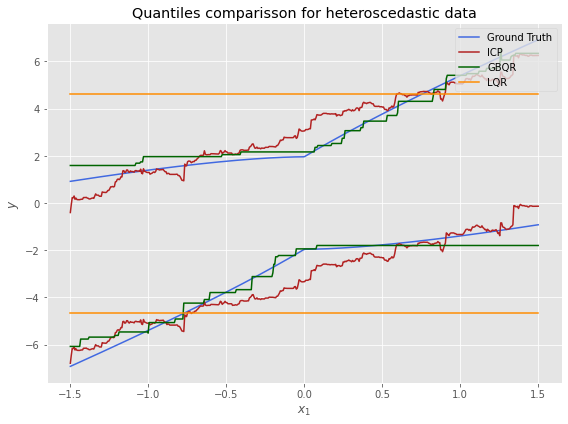

In [88]:
plot_intervals(kind = "heteroscedastic", figname = "quantile_hetero_beta1_2_d_20.pdf")

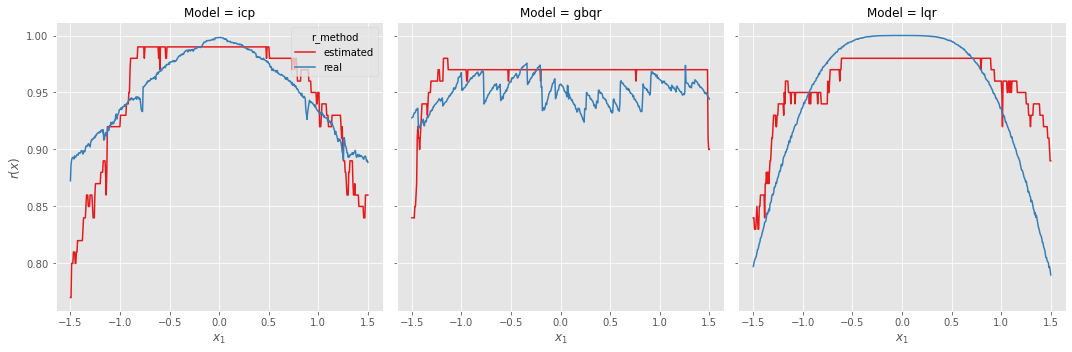

In [7]:
plot_r(kind = "heteroscedastic", figname = "rx_RF_hetero_beta1_2_d_20.pdf")

Obtaining $\hat{r}(x)$ also for neural net:

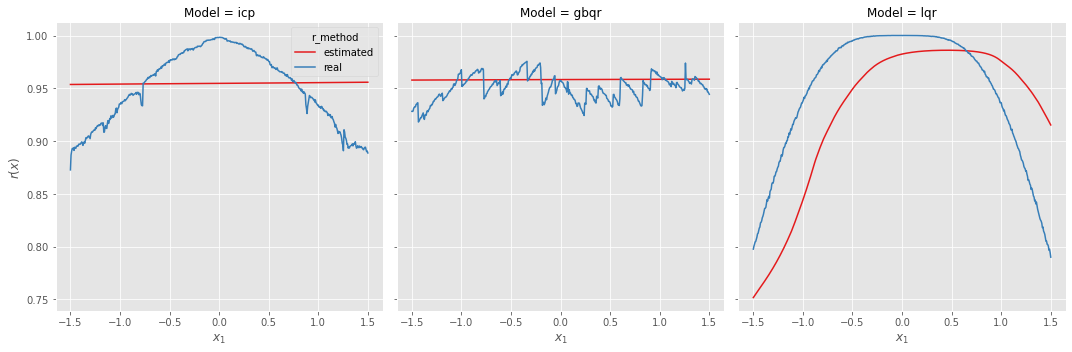

In [8]:
plot_r(kind = "heteroscedastic", coverage_evaluator = "nnet", figname = "rx_nnet_hetero_beta1_2_d_20.pdf")

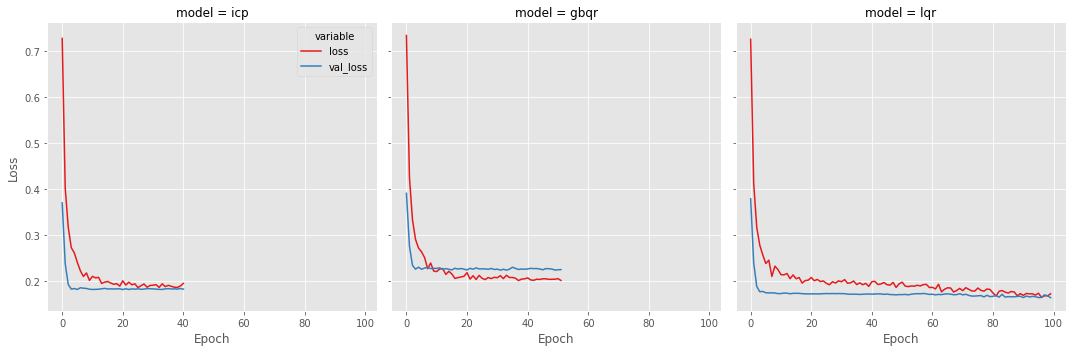

In [9]:
plot_history(kind = "heteroscedastic", figname = "historic_nnet_hetero_beta1_2_d_20.pdf")

Testing with $B = 100$ using nnets:

In [10]:
# using test_methods
# measuring time
start = time.time()
print("Heteroscedastic data hypothesis testing:")
res_het = test_methods(kind = "heteroscedastic", B = 100, coverage_evaluator = "nnet")
end = time.time() - start
print("Time Elapsed: ", end)
res_het

Heteroscedastic data hypothesis testing:
Time Elapsed:  2141.9135234355927


{'ICP': {'p-value': 0.81, 'Observed statistic': 0.009587895},
 'GB Quantile Reg': {'p-value': 0.97, 'Observed statistic': 0.006233047},
 'Linear Quantile Reg': {'p-value': 0.0, 'Observed statistic': 0.038457643}}